In [18]:
import yfinance as yf
import particles
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

import particles
from particles import distributions as dists
from particles import state_space_models as ssm
from particles import mcmc
from particles import smc_samplers as ssp
from particles.collectors import Moments

In [5]:
sp500 = yf.Ticker("^GSPC")
sp500.info

{'exchange': 'SNP',
 'shortName': 'S&P 500',
 'exchangeTimezoneName': 'America/New_York',
 'exchangeTimezoneShortName': 'EST',
 'isEsgPopulated': False,
 'gmtOffSetMilliseconds': '-18000000',
 'quoteType': 'INDEX',
 'symbol': '^GSPC',
 'messageBoardId': 'finmb_INDEXGSPC',
 'market': 'us_market',
 'previousClose': 3822.39,
 'regularMarketOpen': 3815.11,
 'twoHundredDayAverage': 4016.8584,
 'trailingAnnualDividendYield': None,
 'payoutRatio': None,
 'volume24Hr': None,
 'regularMarketDayHigh': 3845.8,
 'navPrice': None,
 'averageDailyVolume10Day': 4394980000,
 'totalAssets': None,
 'regularMarketPreviousClose': 3822.39,
 'fiftyDayAverage': 3885.7617,
 'trailingAnnualDividendRate': None,
 'open': 3815.11,
 'toCurrency': None,
 'averageVolume10days': 4394980000,
 'expireDate': None,
 'yield': None,
 'algorithm': None,
 'dividendRate': None,
 'exDividendDate': None,
 'beta': None,
 'circulatingSupply': None,
 'startDate': None,
 'regularMarketDayLow': 3797.01,
 'priceHint': 2,
 'currency': 

In [23]:
period = "2y"

df_sp500 = sp500.history(start="1996-01-01", end="2015-12-31")
df_sp500.shape

(5035, 7)

In [24]:
df_sp500.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

In [8]:
# Parameters for SV, SVJR, SVJV, SVCJ models

# speed of mean reversion
kappa = None
# unconditional mean variance
theta = None
# variance of variance
sigma = None
# corr between Brownian motions
rho = None
# diffusive equity risk premium (linear in Vt)
eta_s = None
# diffusive variance risk premium
eta_v = None

# jump intensity for Poisson process
lbda = None
# mean of the return jump size
mu_s = None
# standard deviation of the return jump size
sigma_s = None
# mean jump sizes of return
eta_J_s = None
# params of Exp()
mu_v = None
# mean jump sizes of variance
eta_J_v = None
# correlation
rho_J = None
#
sigma_c = None

# Others

# risk-free rate
rt = None
# dividend yield
delta_t = None
# index level
St = None

In [30]:
df_sp500["Log-return"] = np.log(df_sp500.Close / df_sp500.Open)

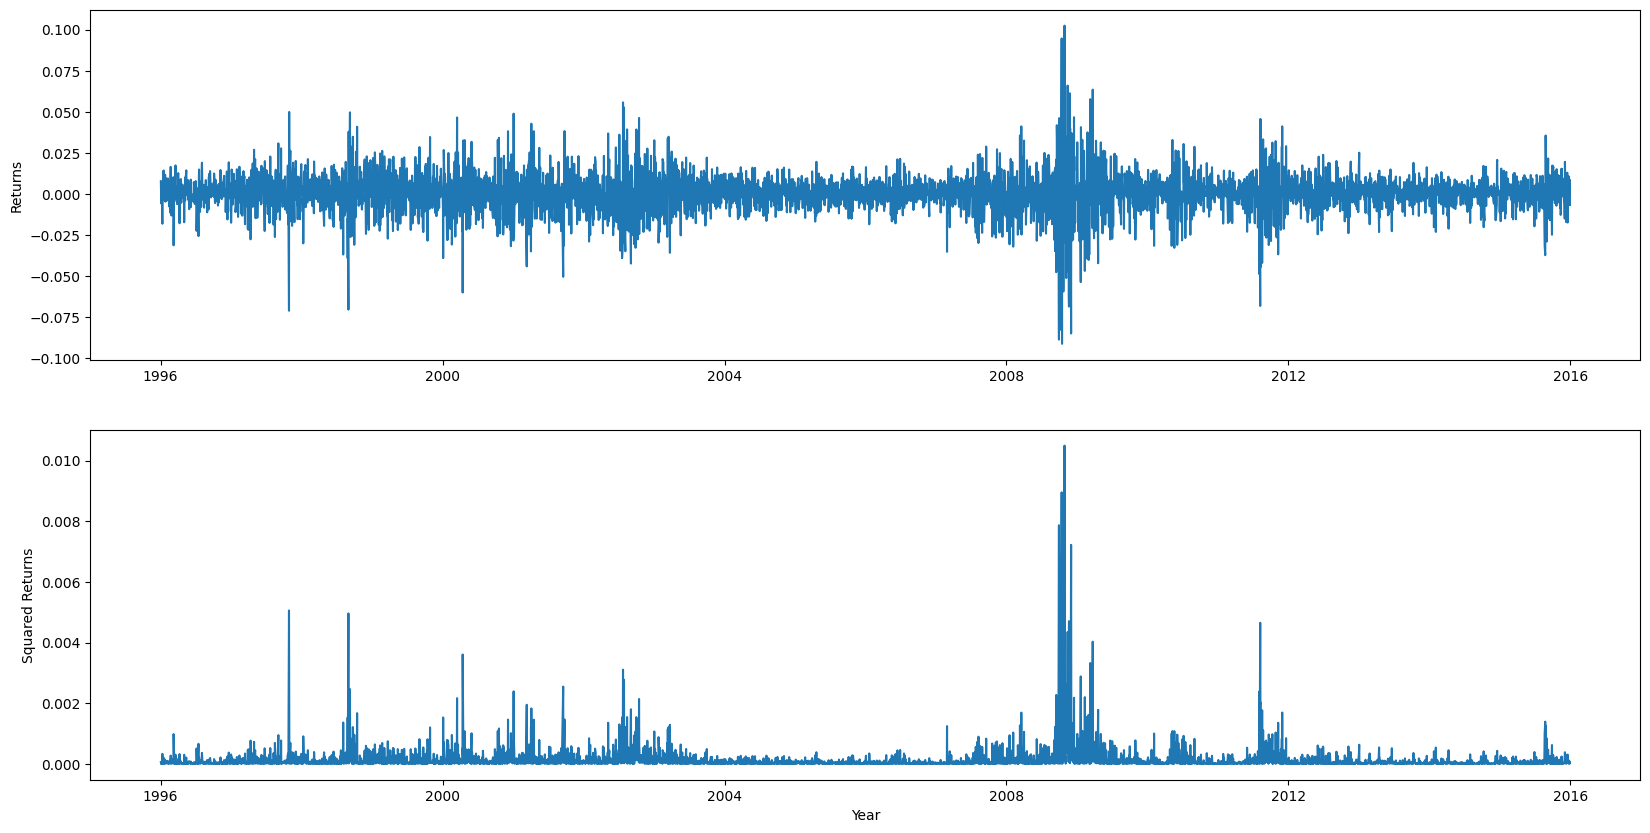

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(df_sp500["Log-return"])
plt.ylabel("Returns")
plt.subplot(2, 1, 2)
plt.plot(df_sp500["Log-return"]**2)
plt.ylabel("Squared Returns")
plt.xlabel("Year")
plt.show()

In [ ]:
class StochVol(ssm.StateSpaceModel):
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=0., scale=np.exp(x))

stoch_vol_model = StochVol()

In [ ]:
class HestonVol(ssm.StateSpaceModel):
    def PX0(self):
        return
    def PX(self, t, xp):
        return
    def PY(self, t, xp, x):
        return

stoch_vol_model = HestonVol()

In [ ]:
class SVJR(ssm.StateSpaceModel):
    """
    Model with return jumps
    """
    def PX0(self):
        return
    def PX(self, t, xp):
        return
    def PY(self, t, xp, x):
        return

In [ ]:
class SVJV(ssm.StateSpaceModel):
    """
    Model with variance jumps
    """
    def PX0(self):
        return
    def PX(self, t, xp):
        return
    def PY(self, t, xp, x):
        return

In [ ]:
Nt = dists.Poisson(lbda)

class SVCJ(ssm.StateSpaceModel):
    """
    Model with correlated return and variance jumps
    """
    def PX0(self):
        return
    def PX(self, t, xp):
        return
    def PY(self, t, xp, x):
        return

# Bootstrap filter

In [ ]:
ssm.Bootstrap()

# PMMH

In [ ]:
mcmc.PMMH()

# Orthogonal MCMC

# SMC^2

In [ ]:
ssp.SMC2()